In [1]:
import duckdb as db
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Using top 10% of allignemnt results 

### Connect to existing DuckDB database, prep and run queries

In [ ]:
con = db.connect(database='/ptmp/pboppert/Pathocom/diamond-postprocess-playground/code/Bacteria_to_UniRef_pipeline/data_top90/matrix.db', read_only=True)

┌─────────┐
│ threads │
│  int64  │
├─────────┤
│     256 │
└─────────┘



**Collects per sample GO term/Protein cluster abundances if read and assembled data contains vaules**

In [ ]:
query_go_terms = """
    WITH pivot_alias AS (
    PIVOT
    (
    SELECT 
        * exclude (sseqid) 
    FROM 
        go_abundance
    )
    ON 
        type
    USING 
        SUM(sum_proportion)
    )
    SELECT 
        *
    FROM
        pivot_alias
    WHERE 
        assembled IS NOT NULL
    AND 
        reads IS NOT NULL
    """

In [ ]:
query_proteins = """
    WITH pivot_alias AS (
    PIVOT
    (
    SELECT 
        *
    FROM 
        protein_abundance
    )
    ON 
        type
    USING 
        SUM(sum_proportion)
    )
    SELECT 
        *
    FROM
        pivot_alias
    WHERE 
        assembled IS NOT NULL 
    AND 
        reads IS NOT NULL
    """

**Collects per sample GO term abundances, missing values are denoted with -1**

In [ ]:
query_go_terms_included_nulls = """
    WITH pivot_alias AS (
    PIVOT
    (
    SELECT 
        * exclude (sseqid) 
    FROM 
        go_abundance
    )
    ON 
        type
    USING 
        SUM(sum_proportion)
    )
    SELECT 
        if (assembled is NULL, -1, assembled) AS assembled,
        if (reads is NULL, -1, reads) AS reads
    FROM
        pivot_alias
    """

In [ ]:
query_proteins_included_nulls = """
    WITH pivot_alias AS (
    PIVOT
    (
    SELECT 
        *
    FROM 
        protein_abundance
    )
    ON 
        type
    USING 
        SUM(sum_proportion)
    )
    SELECT 
        if (assembled is NULL, -1, assembled) AS assembled,
        if (reads is NULL, -1, reads) AS reads
    FROM
        pivot_alias
    """

In [ ]:

con.sql(query_go_terms).write_parquet('scatterplot_data_go.pq')

In [ ]:
# plot pivot matrix as single values: proteins 
con.query(query_proteins).write_parquet('scatterplot_data_proteins.pq')

In [ ]:
con.query(query_go_terms_included_nulls).write_parquet('scatterplot_data_go_nulls.pq')

In [ ]:
con.query(query_proteins_included_nulls).write_parquet('scatterplot_data_proteins_nulls.pq')

In [ ]:
# Scatter plot read cell values vs assmbled cell values
def scatter_plot(file, title):
    # Read data from database
    df = pd.read_parquet(file)
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='reads', y='assembled')
    plt.title(title)
    plt.xlabel('Read Cell Values')
    plt.ylabel('Assembled Cell Values')
    plt.show()
    


**Scatter plots of read vs assmbled count values**

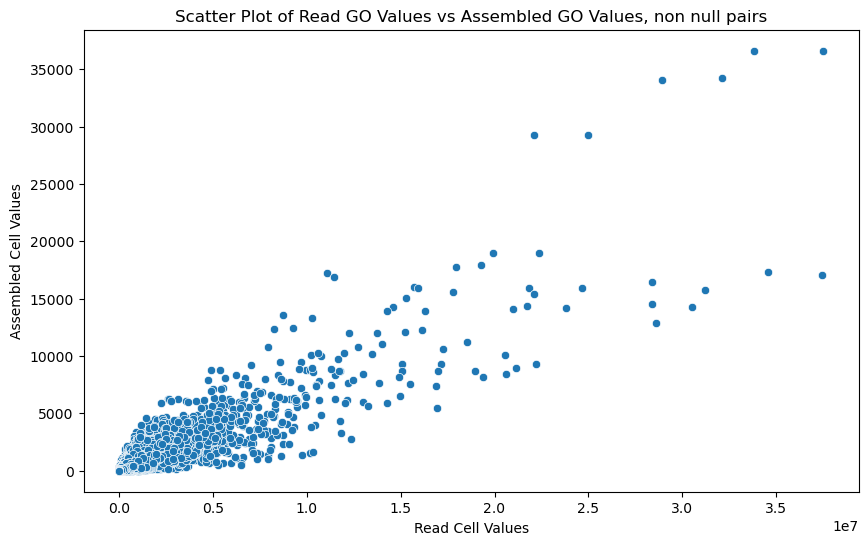

In [ ]:
# plot pivot matrix as single values: GO TERMS
scatter_plot('scatterplot_data_go.pq', 'Scatter Plot of Read GO Values vs Assembled GO Values, non null pairs')

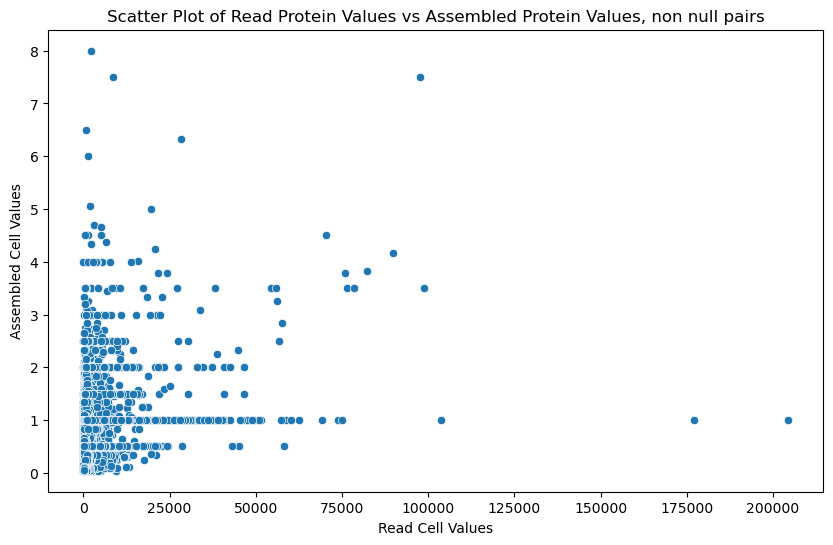

In [ ]:
scatter_plot('scatterplot_data_proteins.pq', 'Scatter Plot of Read Protein Values vs Assembled Protein Values, non null pairs')

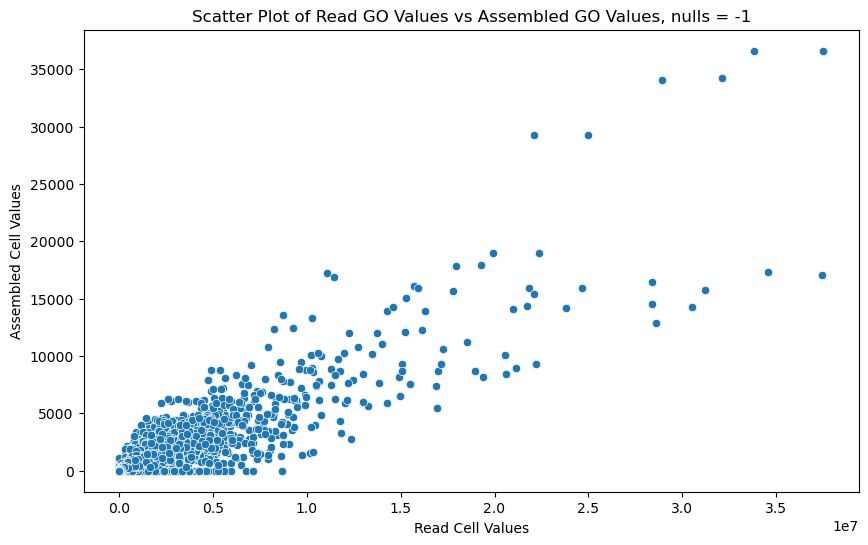

In [ ]:
scatter_plot('scatterplot_data_go_nulls.pq', 'Scatter Plot of Read GO Values vs Assembled GO Values, nulls = -1')

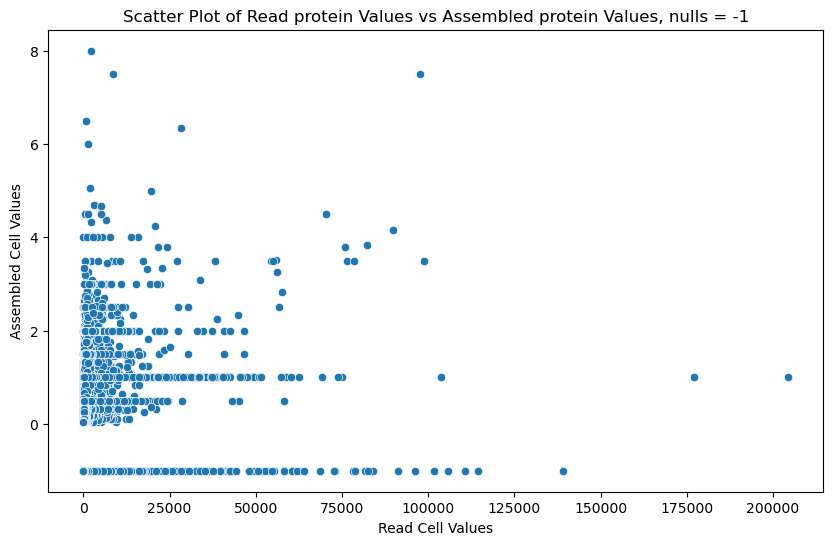

In [ ]:
scatter_plot('scatterplot_data_proteins_nulls.pq', 'Scatter Plot of Read protein Values vs Assembled protein Values, nulls = -1')

### Collect and plot general distribution of count values

In [ ]:
con.query("SELECT sum_proportion FROM protein_abundance WHERE type ='reads' USING SAMPLE 30%").write_parquet('protein_abundance_reads.pq')


In [ ]:
con.query("SELECT sum_proportion FROM protein_abundance WHERE type ='assembled' USING SAMPLE 30%").write_parquet('protein_abundance_assembled.pq')

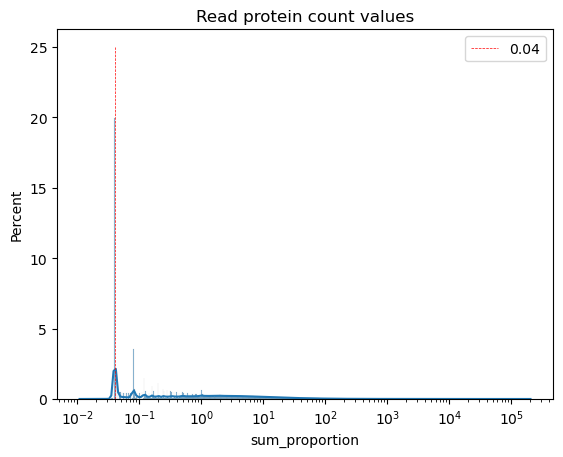

In [ ]:

# Get data from database
plt = sns.histplot(x = pd.read_parquet('protein_abundance_reads.pq')['sum_proportion'], log_scale= True, kde=True, stat = 'percent')
plt.vlines(0.04,0, 25, lw = 0.5, color='r', linestyle='--', label="0.04")
plt.set_title("Read protein count values")
plt.legend()

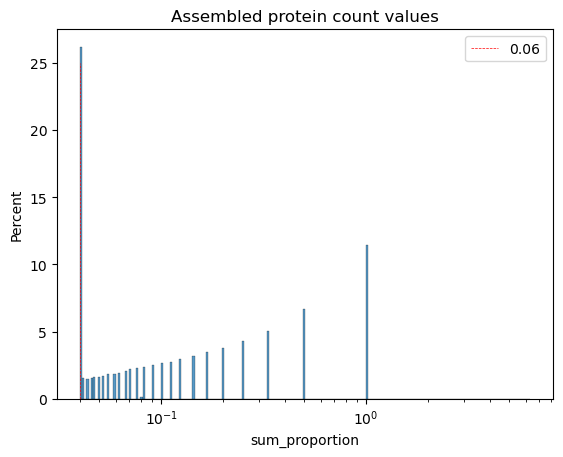

In [ ]:
plt = sns.histplot(x = pd.read_parquet('protein_abundance_assembled.pq')['sum_proportion'], log_scale= True, kde=False, stat = 'percent', bins = 200)
plt.vlines(0.04,0, 25, lw = 0.5, color='r', linestyle='--', label="0.06")
plt.set_title("Assembled protein count values")
plt.legend()

### Plot heatmaps and distribution of heatmap cell values

In [12]:
def plot_distribution_line(file, fig_name, axis):

    data = pd.read_parquet(file)
    if "sseqid" in data.columns:
        data.drop(columns=["sseqid"], inplace=True)
    else:
        data.drop(columns=["go"], inplace=True)

    sns.lineplot(data, x= data.index, y = data["cumulative_sum_perc"], ax = axis, legend = True)
    axis.hlines(y=0.95, xmin=0.0, xmax = max(data.index), color='r', linestyle='-', label="95%")
    axis.hlines(y=0.99, xmin=0.0, xmax = max(data.index), color='g', linestyle='-', label="99%")
    axis.set_title(fig_name)
    axis.set_ylabel("Percentage of total counts (cumulative)")
    axis.set_xlabel("Rank (by number of counts DESC)")
    axis.legend()

In [11]:
def plot_distribution_heatmap(file, f_mask,  go_order=None, sample_order=None):
    
    # read data 
    data = pd.read_parquet(file)
    data.set_index("isolate", inplace=True)
    
    # order go terms, from previous clustering 
    if go_order is not None:
        missing = list(set(go_order) - set(data.columns))
        print(f"Missing GO terms: {len(missing)}")
        data = data.reindex(columns=go_order, fill_value=0)
        data = data.reindex(sample_order)
        data = data.loc[:, go_order]
        col = pd.DataFrame()
        col["name"] = data.columns
        col["missing"] = col.apply(lambda x: 'red' if x["name"] in missing else 'white', axis=1)
        col.set_index("name", inplace=True)
        col = col.loc[go_order]
    
    # fill missing values, nan breaks clustering
    # data.fillna(0, inplace=True)
    mask = f_mask(data)
    data.where(mask, 0, inplace=True)

    # plot clustered heatmap, if go_order is given use same orde of columns 
    plt.rcParams["figure.figsize"] = (10,10)
    clustered_heatmap = sns.clustermap(data,mask = ~mask,
                                        col_cluster=True if go_order is None else False,
                                        row_cluster=True if sample_order is None else False, 
                                        col_colors= None if go_order is None else col)


    # get clusterd order of go terms
    if go_order is None:
        go_order = [data.columns[i] for i in clustered_heatmap.dendrogram_col.reordered_ind]
        row_order = [data.index[i] for i in clustered_heatmap.dendrogram_row.reordered_ind]
    else:
        go_order = None
        row_order = None
    plt.show()
    
    return [go_order, row_order]




In [10]:
def plot_subgraphs():
    fig, axs = plt.subplots(2,2, squeeze=False, figsize=(15, 15))
    
    # Get data go terms assembled data
    data = pd.read_parquet("data_top90/assmbled_go_matrix.pq")
    data.set_index("isolate", inplace=True)
    flatt = data.to_numpy().flatten()
    
    # plot histogram
    sns.histplot(x = flatt, log_scale= True, kde=True, stat = 'percent', ax = axs[0,0])
    axs[0,0].axvline(1.0, 0,1, lw = 0.5, color='r', linestyle='--', label="1.0")
    axs[0,0].set_title("Assembled GO terms, cell values")
    axs[0,0].set_xlabel("Count value")
    axs[0,0].legend()

    data.where(data > 1, np.nan, inplace=True)
    sns.heatmap(data, cbar_kws={'label': 'Counts'}, ax = axs[1,0])
    axs[1,0].set_title("Assembled GO terms, cell values > 1.0")

    # Get data go terms reads data
    data_2 = pd.read_parquet("data_top90/reads_go_matrix.pq")
    data_2.set_index("isolate", inplace=True)
    flatt_2 = data_2.to_numpy().flatten()

    # plot histogram
    sns.histplot(x = flatt_2, log_scale= True, kde=True, stat = 'percent', ax = axs[0,1])
    axs[0,1].axvline(500, 0,1, lw = 0.5, color='r', linestyle='--', label="500")
    axs[0,1].set_title("Read GO terms, cell values")
    axs[0,1].set_xlabel("Count value")
    axs[0,1].legend()


    # filtyer and set column, row order same as assembled data
    data_2.where(data_2 > 500, np.nan, inplace=True)
    data_2 = data_2.reindex(columns=data.columns, fill_value=0)
    data_2 = data_2.reindex(index=data.index, fill_value=0)
    data_2 = data_2.loc[:, data.columns]


    sns.heatmap(data_2, cbar_kws={'label': 'Counts'}, ax = axs[1,1])
    axs[1,1].set_title("Read GO terms, cell values > 500")


    # plt.savefig("data_top90/cell_value_histogramm_and_heatmap", dpi = 300)
    plt.show()

/viper/u/pboppert/micromamba/envs/Pathocom/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


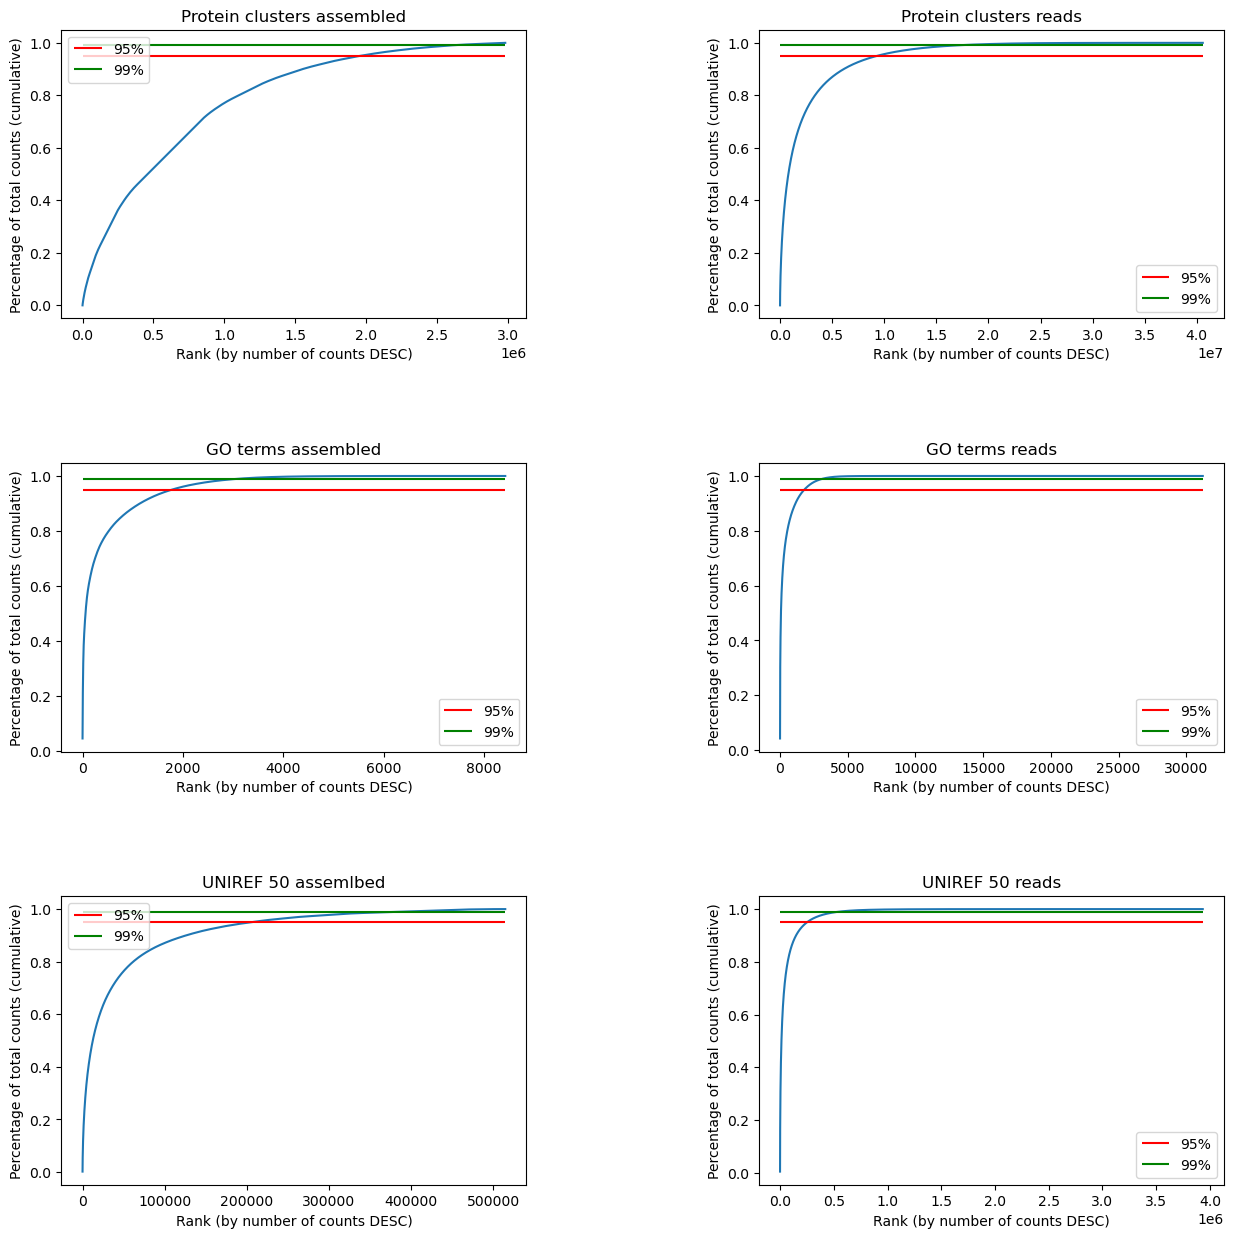

In [5]:
# Plot cumlative sum of UNIREF90 clusters, go term counts, UNIREF50 clusters
# Rank of counts vs percentage of total counts
fig, axs = plt.subplots(3,2, squeeze=False, figsize=(15, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for x, y, z in zip(["data_top90/assembled_protein_clusters_dist.pq", "data_top90/reads_protein_clusters_dist.pq", "data_top90/assembled_go_dist.pq", "data_top90/reads_go_dist.pq", "data_top90/protein_clusters_dist_UNREF50_assembled.pq", "data_top90/protein_clusters_dist_UNREF50_reads.pq", ], [axs[0,0], axs[0,1], axs[1,0], axs[1,1], axs[2,0], axs[2,1]], ["Protein clusters assembled", "Protein clusters reads", "GO terms assembled", "GO terms reads", "UNIREF 50 assemlbed", "UNIREF 50 reads"]):
    plot_distribution_line(x, z, axis = y)
# plt.savefig("data_top90/Cumluative_distribution_protein_go.png", dpi = 300)
plt.show()

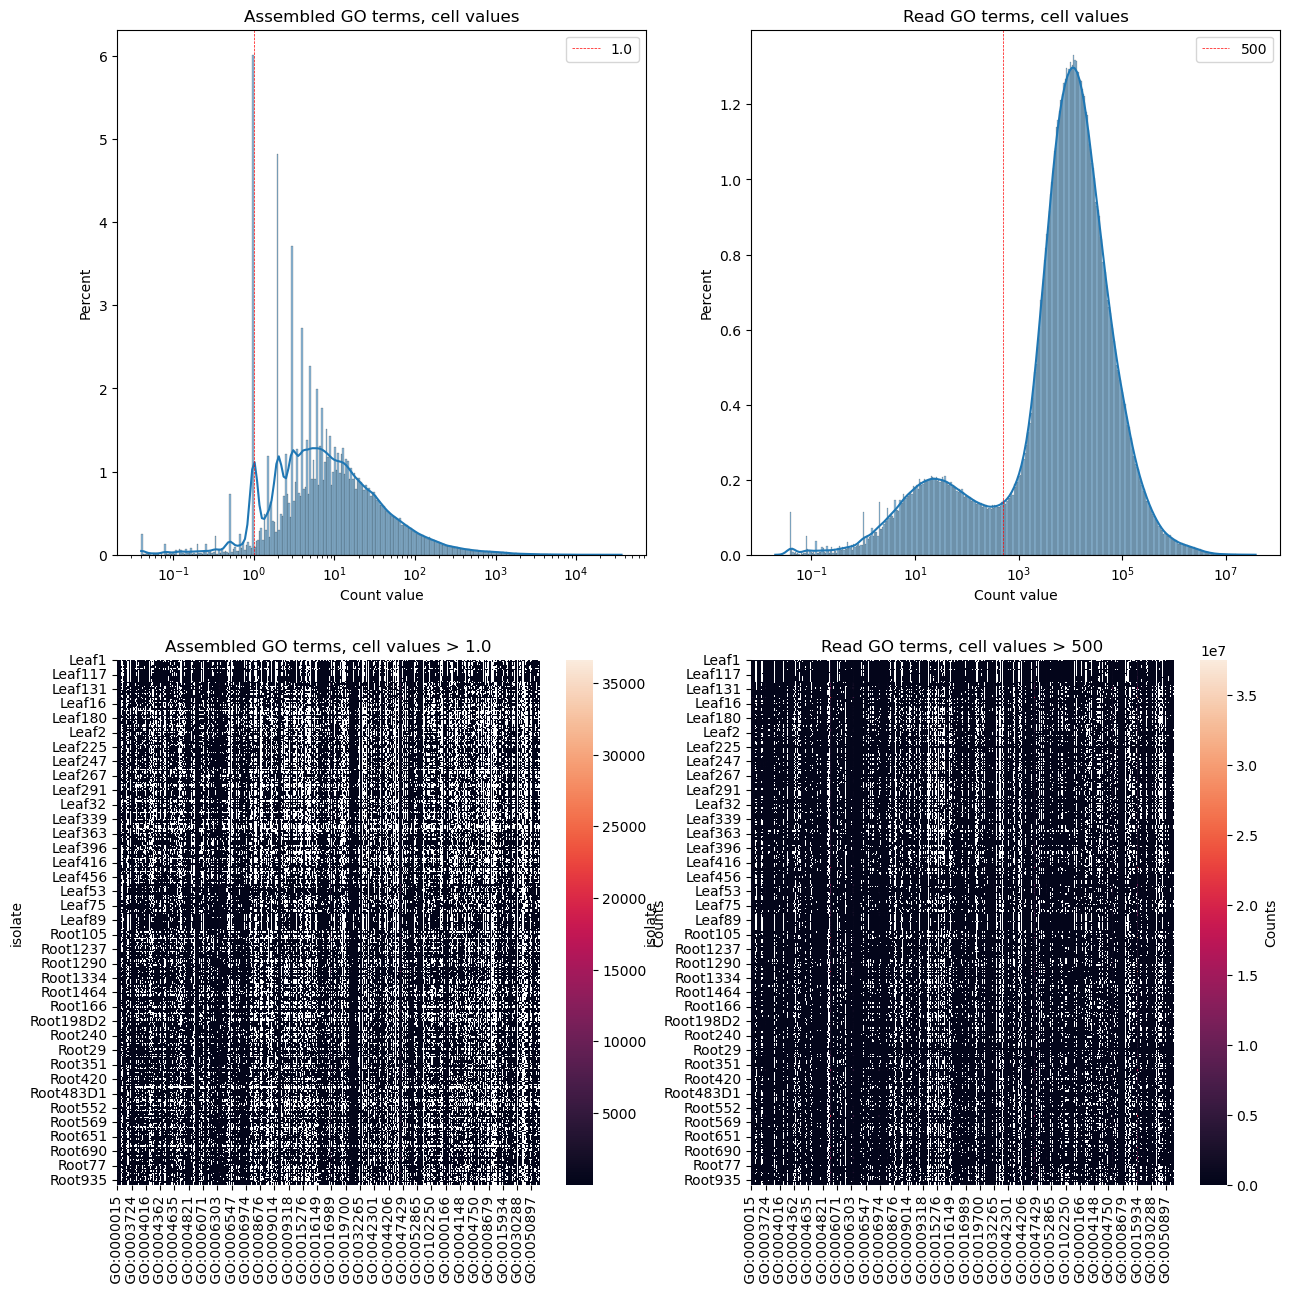

In [9]:
# Plot histogramm cell values distribution and histogramms
plot_subgraphs()

/viper/u/pboppert/micromamba/envs/Pathocom/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/viper/u/pboppert/micromamba/envs/Pathocom/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


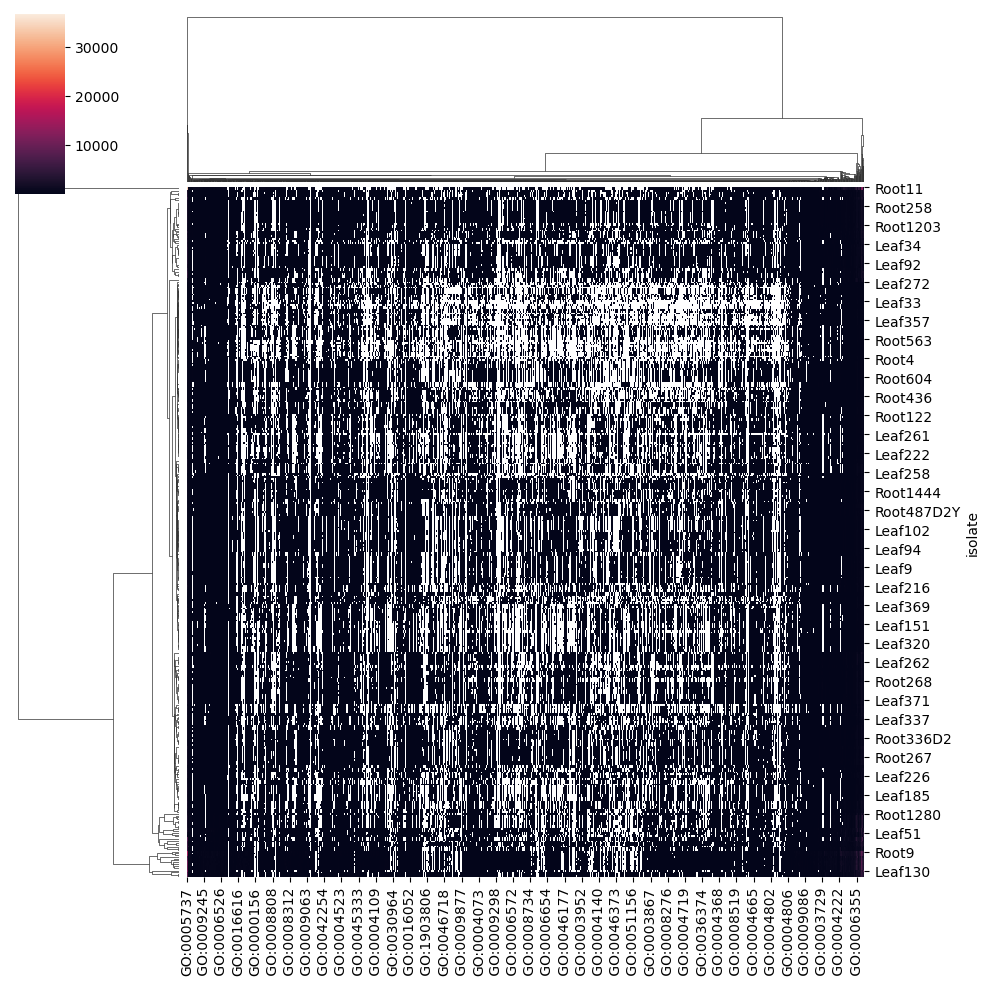

In [13]:
# Clustred heatmaps, GO terms assembled and reads, values filter via given function
go_order, row_order = plot_distribution_heatmap("data_top90/assmbled_go_matrix.pq",f_mask=lambda x: x > 1.0)


Missing GO terms: 165


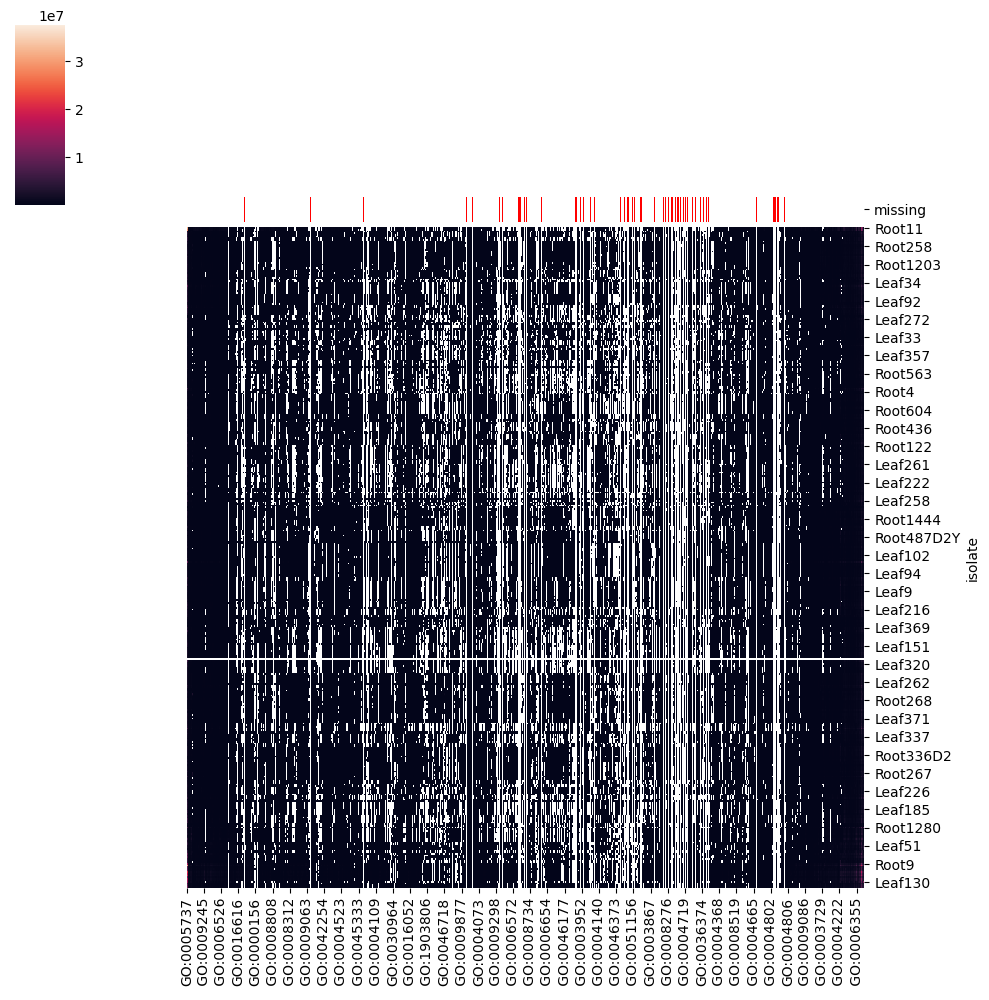

[None, None]

In [14]:
plot_distribution_heatmap("data_top90/reads_go_matrix.pq",lambda x: x > 500 , go_order, row_order)
